In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from math import exp

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, Margin, IMC_Tuning
import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

from importlib import reload
package_LAB = reload(package_LAB)

## Calcul de DV0 & PV0

In [576]:
nameFile1 = 'Open_loop_experiment_on_MV_2024-03-18-09h26.txt'

titleName1 = nameFile1.split('.')[0]
data1 = pd.read_csv(nameFile1)
t1 = data1['t'].values - data1['t'].values[0]

PV0 = 0
for i in range(len(t1)):
    PV0 += data1['PV'].values[i]
PV0 = PV0/len(t1)
print(PV0)

nameFile2 = 'Open_loop_experiment_on_DV_2024-03-18-19h49.txt'

titleName2 = nameFile2.split('.')[0]
data2= pd.read_csv(nameFile2)
t2 = data2['t'].values - data2['t'].values[0]

DV0 = 0
for i in range(len(t2)):
    DV0 += data2['PV'].values[i]
DV0 = DV0/len(t2)
print(DV0)

70.1002900552487
71.16462850182711


## Simulation Closed loop Parameters

In [577]:
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 70

t = []
MV = [MV0]

MV1 = [MV0]
MV2 = [MV0]

E1 = []
E2 = []

SP = []

PV1 = []
PV2 = []

PV1p1 = []
PV2p1 = []
PV1d1 = []
PV2d1 = []

PV1p2 = []
PV2p2 = []
PV1d2 = []
PV2d2 = []


DV = []
Man = []
MVMan = []

MVFF1 = []
MVFF2 = []

MVFF_Delay1 = []
MVFF_Delay2 = []

MVFFdv1 = []
MVFFpv1 = []

MVFFdv2 = []
MVFFpv2 = []

MV_Delayp1 = []
MV_Delayd1 = []
MV_Delayp2 = []
MV_Delayd2 = []

MVP1 = []
MVI1 = []
MVD1 = []

MVP2 = []
MVI2 = []
MVD2 = []


# Parameters
Kp = 1
Kd1 = 1
Kd2 = 1
KpExp = 0.4971
KdExp = 0.3734
Kff1 = KdExp/KpExp #0.7512
Kff2 = Kff1


theta_ffExp = max(0, theta_dExp-theta_pExp)

MVMin = 0
MVMax = 100

T1d = 153.9969
T2d = 42.4662

T1p = 201.8353
T2p = 14.1389


T1 = T1p
T2 = T2p


## Scenario

In [578]:
Scenario = "Response to DV : No FF and controller in automatic mode"

if(Scenario == "Closed-loop response to a setpoint change SP"):
    TSim = 1000

    SPPath =  {0:50, TSim:50}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:0, TSim:0}
    ManFF = True
    
    DVState = True
    FFShown = False
    MVManShown = False
    
    NumRTsteps = TSim

if(Scenario == "Response to DV : No FF and controller in manual mode"):
    TSim = 2500

    MVManPath = {0:50, 750:75, 1400:65, TSim:65}
    SPPath = MVManPath
    ManPath = {0:True, TSim:True}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = True
    
    DVState = True
    FFShown = False
    MVManShown = True
    
    NumRTsteps = TSim
    
    Kp1 = 1
    Kp2 = 2
    
    theta_p1 = 4.386
    theta_d1 = 12.181
    
    theta_p2 = theta_p1
    theta_d2 = theta_d1 
    
    alpha1 = 0.9
    alpha2 = 0.9
    
    gamma1 = 0.6
    gamma2 = 0.6
    
if(Scenario == "Response to DV : FF and controller in manual mode"):
    TSim = 2500

    MVManPath = {0:50, 750:75, 1400:65, TSim:65}
    SPPath = MVManPath
    ManPath = {0:True, TSim:True}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = False
    
    DVState = True
    FFShown = True
    MVManShown = True
    
    NumRTsteps = TSim
    
    Kp1 = 1
    Kp2 = 1
    
    theta_p1 = 4.386
    theta_d1 = 12.181
    
    theta_p2 = theta_p1
    theta_d2 = theta_d1 
    
    alpha1 = 0.9
    alpha2 = 0.9
    
    gamma1 = 0.6
    gamma2 = 0.6
    
if(Scenario == "Response to DV : No FF and controller in automatic mode"):
    TSim = 2500

    SPPath = {0:75, 750:75, 1400:65, TSim:65}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = True
    
    DVState = True
    FFShown = False
    MVManShown = False
    
    NumRTsteps = TSim
    
    Kp1 = 1
    Kp2 = 1
    
    theta_p1 = 4.386
    theta_d1 = 12.181
    
    theta_p2 = theta_p1
    theta_d2 = theta_d1 
    
    alpha1 = 0.9
    alpha2 = 0.9
    
    gamma1 = 0.6
    gamma2 = 0.3
    
if(Scenario == "Response to DV : FF and controller in automatic mode"):
    TSim = 2500

    SPPath = {0:75, 750:75, 1400:65, TSim:65}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = False
    
    DVState = True
    FFShown = True
    MVManShown = False
    
    NumRTsteps = TSim
    
    Kp1 = 1
    Kp2 = 1
    
    theta_p1 = 4.386
    theta_d1 = 12.181
    
    theta_p2 = theta_p1
    theta_d2 = theta_d1 
    
    alpha1 = 0.9
    alpha2 = 0.9
    
    gamma1 = 0.6
    gamma2 = 0.6
    
    Kff1 = 0.75
    Kff2 = 1
    
    Kd1 = 0.75
    Kd2 = 1

## Simulation Closed loop


(0.0, 2500.0)

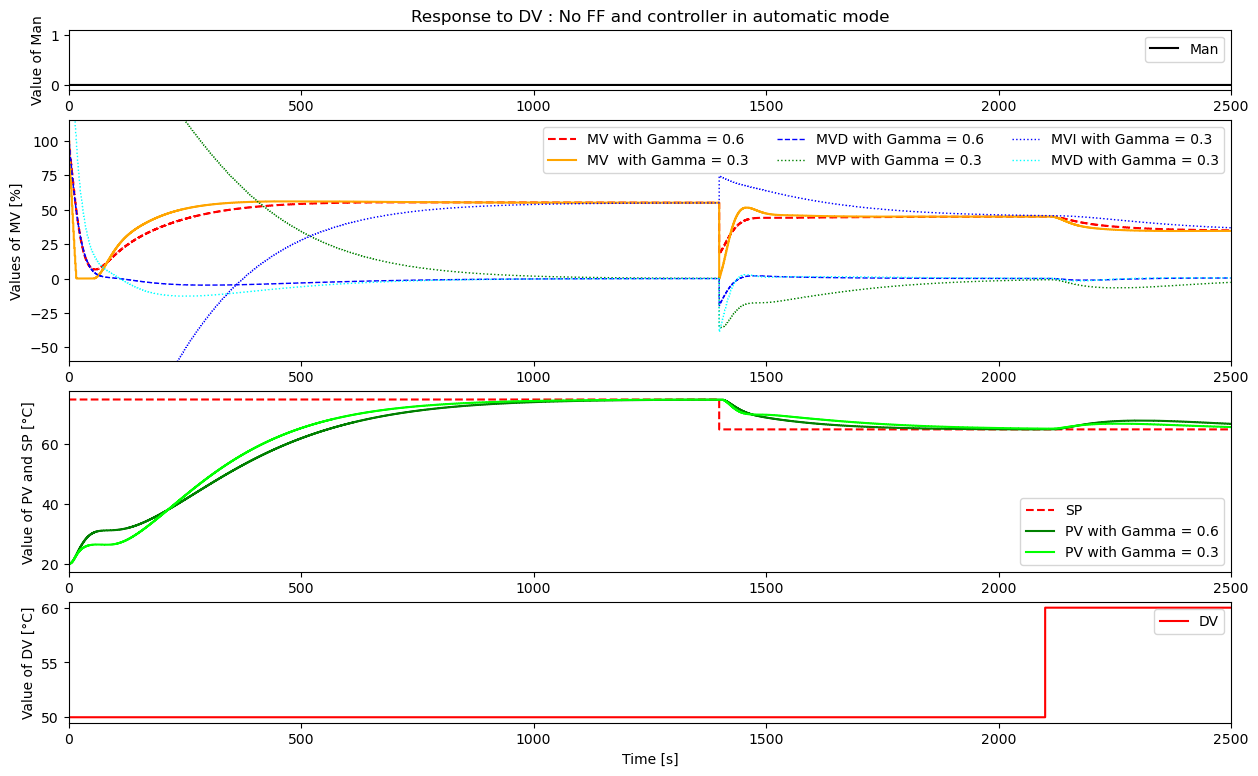

In [579]:
[Kc1, Ti1, Td1] = IMC_Tuning(T1, T2, T1p, gamma1, Kp1, "B")
[Kc2, Ti2, Td2] = IMC_Tuning(T1, T2, T1p, gamma2, Kp2, "B")


for i in range(0,N-1):
    t.append(i*Ts)
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(MVManPath,t,MVMan)
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(DVPath,t,DV)
    
    
    #MVFF
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([theta_d1-theta_p1,0]),Ts,MVFF_Delay1, DV0)
    
    LeadLag_RT(MVFF_Delay1, -Kff1, T1p, T1d, Ts, MVFFdv1)
    LeadLag_RT(MVFFdv1, 1, T2p, T2d, Ts, MVFF1)

    
    PID_RT(SP, PV1, Man, MVMan, MVFF1, Kc1, Ti1, Td1, alpha1, Ts, MVMin, MVMax, MV1, MVP1, MVI1, MVD1, E1, ManFF)
    
    
    
    Delay_RT(MV1, theta_p1, Ts, MV_Delayp1, MV0)
    
    FO_RT(MV_Delayp1,Kp1,T1p,Ts,PV1p1,0)
    FO_RT(PV1p1,1,T2p,Ts,PV2p1,0)
    
    Delay_RT(DV - DV0*np.ones_like(DV),theta_d1,Ts,MV_Delayd1, DV0)
    
    FO_RT(MV_Delayd1,Kd1,T1d,Ts,PV1d1,0)
    FO_RT(PV1d1,1,T2d,Ts,PV2d1,0)
    
    PV1.append(PV2p1[-1] + PV2d1[-1] + PV0-Kp1*MV0)
    
    
    
    
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([theta_d2-theta_p2,0]),Ts,MVFF_Delay2, DV0)
    
    LeadLag_RT(MVFF_Delay2, -Kff2, T1p, T1d, Ts, MVFFdv2)
    LeadLag_RT(MVFFdv2, 1, T2p, T2d, Ts, MVFF2)
    

    
    PID_RT(SP, PV2, Man, MVMan, MVFF2, Kc2, Ti2, Td2, alpha2, Ts, MVMin, MVMax, MV2, MVP2, MVI2, MVD2, E2, ManFF)
    
    
    
    Delay_RT(MV2, theta_p2, Ts, MV_Delayp2, MV0)
    
    FO_RT(MV_Delayp2,Kp2,T1p,Ts,PV1p2,0)
    FO_RT(PV1p2,1,T2p,Ts,PV2p2,0)
    
    Delay_RT(DV - DV0*np.ones_like(DV),theta_d2,Ts,MV_Delayd2, DV0)
    
    FO_RT(MV_Delayd2,Kd2,T1d,Ts,PV1d2,0)
    FO_RT(PV1d2,1,T2d,Ts,PV2d2,0)
    
    PV2.append(PV2p2[-1] + PV2d2[-1] + PV0-Kp2*MV0)
    
    
fig, ax = plt.subplots(4, 1, gridspec_kw={'height_ratios': [1, 4, 3, 2]})


fig.set_figheight(9)
fig.set_figwidth(15)

ax[0].step(t,Man,'black',label='Man',where='pre')
ax[0].set_ylabel('Value of Man')
ax[0].set_title(Scenario)
ax[0].legend(loc="best")
ax[0].set_xlim([0, TSim])
ax[0].set_ylim([-0.100,1.100])

ax[1].step(t,MV1,'red', label='MV with Gamma = 0.6', ls = '--', where='pre')
ax[1].step(t,MV2,'orange',label='MV  with Gamma = 0.3',where='pre')
#ax[1].step(t,MVP1,'green',label='MVP',where='pre', ls = '--', linewidth = '1' )
#ax[1].step(t,MVI1,'blue',label='MVI',where='pre', ls = '--', linewidth = '1')
ax[1].step(t,MVD1,'blue',label='MVD with Gamma = 0.6',where='pre', ls = '--', linewidth = '1')
ax[1].step(t,MVP2,'green',label='MVP with Gamma = 0.3',where='pre', ls = ':', linewidth = '1' )
ax[1].step(t,MVI2,'blue',label='MVI with Gamma = 0.3',where='pre', ls = ':', linewidth = '1')
ax[1].step(t,MVD2,'cyan',label='MVD with Gamma = 0.3',where='pre', ls = ':', linewidth = '1')
if FFShown == True:
    ax[1].step(t,MVFF1,'black',label='MVFF with Kff = 0.75',where='pre', ls = '--', linewidth = '1')
    ax[1].step(t,MVFF2,'brown',label='MVFF with Kff = 1',where='pre', linewidth = '1')
#if MVManShown == True:
#    ax[1].step(t,MVMan,'black',label='MVMan',where='pre', ls = '--', linewidth = '1')
ax[1].set_ylabel('Values of MV [%]')
ax[1].legend(ncol = 3, loc="upper right", bbox_to_anchor=(1,1))
ax[1].set_xlim([0, TSim])
ax[1].set_ylim([-60,115])


ax[2].step(t,SP,'red', label='SP', ls = '--' ,where='pre')
ax[2].step(t,PV1,'green', label='PV with Gamma = 0.6',where='post')
ax[2].step(t,PV2,'lime', label='PV with Gamma = 0.3',where='post')
ax[2].set_ylabel('Value of PV and SP [°C]')
ax[2].legend(loc="lower right", bbox_to_anchor=(1,0))
ax[2].set_xlim([0, TSim])    

ax[3].step(t,DV,'-r', label='DV',where='post')
ax[3].set_ylabel('Value of DV [°C]')
ax[3].set_xlabel('Time [s]')
ax[3].legend(loc='best')
ax[3].set_xlim([0, TSim]) 



## Phase & Gain Margins

In [580]:
P = Process({})

Am = None
Phim = None


P.parameters['Kp'] = 2
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = theta_pExp

omega = np.logspace(-3, 1, 10000)

P1 = Margin(P,omega, Am, Phim,omegaC=0, omegaU=0, Show=True)

print(P1)

TypeError: unsupported operand type(s) for *: 'complex' and 'NoneType'